# Team Members

Farah Ahmed Atef Abdelhameed Hafez

Mohamed Ibrahim Mohamed Abdelhamid

# **Exercise:** Predicting Chemotherapy Resistance from DNA Methylation Data

### Imports

In [77]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

## 1) Load and inspect the dataset

In [78]:
X = pd.read_csv('methylation.csv')
y = pd.read_csv('chemoresistance_labels.csv')
df = pd.merge(X, y)
df.head()

,Unnamed: 0,CpG_0,CpG_1,CpG_2,CpG_3,CpG_4,CpG_5,CpG_6,CpG_7,CpG_8,...,CpG_41,CpG_42,CpG_43,CpG_44,CpG_45,CpG_46,CpG_47,CpG_48,CpG_49,Chemotherapy_Resistance
0,Cell_0,0.773956,0.438878,0.858598,0.697368,0.094177,0.975622,0.761140,0.786064,0.128114,...,0.832678,0.700265,0.312367,0.832260,0.804764,0.387478,0.288328,0.682496,0.139752,0
1,Cell_1,0.199908,0.007362,0.786924,0.664851,0.705165,0.780729,0.458916,0.568741,0.139797,...,0.696320,0.446156,0.381021,0.301512,0.630283,0.361813,0.087650,0.118006,0.961898,0
2,Cell_2,0.908581,0.699707,0.265870,0.969176,0.778751,0.716890,0.449362,0.272242,0.096391,...,0.490707,0.937826,0.571728,0.473489,0.266976,0.331569,0.520672,0.438911,0.021612,0
3,Cell_3,0.826292,0.896161,0.140249,0.554036,0.108576,0.672240,0.281234,0.659423,0.726995,...,0.240971,0.122758,0.831113,0.153284,0.179268,0.599383,0.874562,0.196435,0.310324,0
4,Cell_4,0.777405,0.971826,0.500741,0.143898,0.013936,0.229656,0.131822,0.677659,0.121833,...,0.796817,0.232641,0.530770,0.606016,0.867739,0.603107,0.412572,0.374184,0.425882,1


In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 52 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               1000 non-null   object 
 1   CpG_0                    970 non-null    float64
 2   CpG_1                    974 non-null    float64
 3   CpG_2                    972 non-null    float64
 4   CpG_3                    977 non-null    float64
 5   CpG_4                    970 non-null    float64
 6   CpG_5                    969 non-null    float64
 7   CpG_6                    970 non-null    float64
 8   CpG_7                    980 non-null    float64
 9   CpG_8                    974 non-null    float64
 10  CpG_9                    975 non-null    float64
 11  CpG_10                   985 non-null    float64
 12  CpG_11                   976 non-null    float64
 13  CpG_12                   977 non-null    float64
 14  CpG_13                   

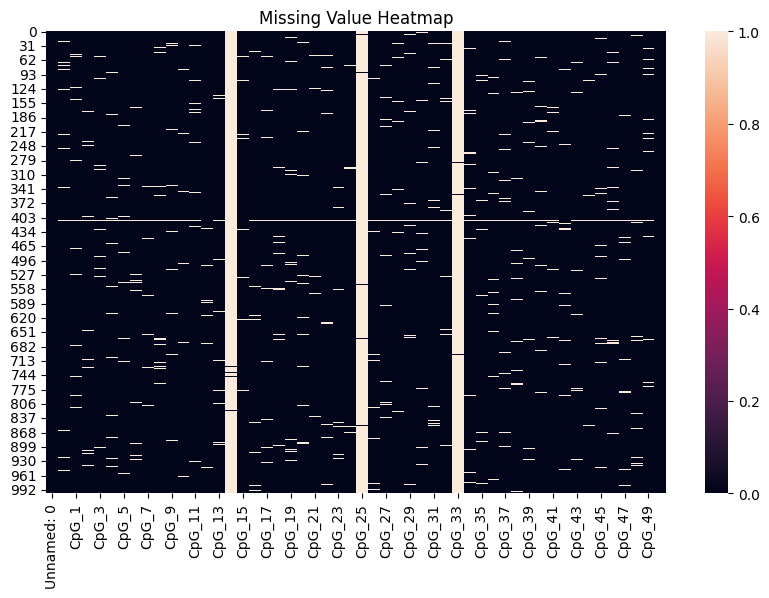

In [80]:
plt.figure(figsize = (10, 6))
sns.heatmap(df.isna())
plt.title('Missing Value Heatmap')
plt.show()

we have explored the missing values and visualised them using a heatmap. Lots of the features have missing values but not the labels.

Text(0.5, 1.0, 'Histogram of the target values')

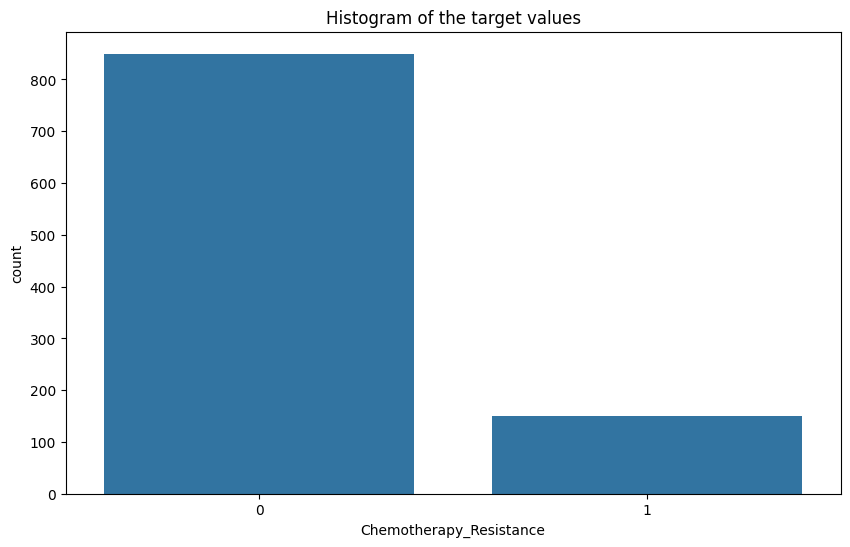

In [81]:
plt.figure(figsize = (10, 6))
sns.countplot(data = df, x = 'Chemotherapy_Resistance')
plt.title('Histogram of the target values')

Here we saw how many samples of each class exist. It can be observed that there is a huge class imbalance.

## 2) Cross Validation

### Preprocessing

In [82]:
cols = ['CpG_14', 'CpG_25', 'CpG_33']
df = df.drop(cols, axis = 1)
# for col in df.columns:
#     if df[col].dtype != 'object':
#         df[col] = df[col].fillna(df[col].median())
# plt.figure(figsize = (10, 6))
# sns.heatmap(df.isna())
# plt.title('Missing Value Heatmap')
# plt.show()

We dropped the above three columns because they almost had all of their values missing. We were first imputing other missing values, but we realised this will cause data leakage because the data that might be later used as the test fold will be used for the imputation causing the leakage.

In [83]:
from sklearn.metrics import roc_auc_score
from scipy import stats

X = df.drop(columns = ['Unnamed: 0', 'Chemotherapy_Resistance'])
y = df['Chemotherapy_Resistance'].values


scaler = StandardScaler()


k = 5
np.random.seed(42)
idx = np.random.permutation(len(X))
fold_size = len(X) // k

roc_auc_dt, roc_auc_rf = [], []


for i in range(k):
    c = i * fold_size
    cc = c + fold_size
    test_idx = idx[c:cc]
    train_idx = np.setdiff1d(idx, test_idx)

    X_train = X.iloc[train_idx]
    X_test = X.iloc[test_idx]
    y_train = y[train_idx]
    y_test = y[test_idx]

    for col in X_train.columns:
      if X_train[col].dtype != 'object':
        X_train.loc[:, col] = X_train[col].fillna(X_train[col].median())
        X_test.loc[:, col] = X_test[col].fillna(X_train[col].median())



    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test  = scaler.transform(X_test)


    rf  = RandomForestClassifier(n_estimators=200, random_state=42)
    dt = DecisionTreeClassifier(random_state=42)

    dt.fit(X_train, y_train)
    rf.fit(X_train, y_train)

    y_pred_dt = dt.predict(X_test)
    y_pred_rf  = rf.predict(X_test)


    roc_auc_dt.append(roc_auc_score(y_test, y_pred_dt))
    roc_auc_rf.append(roc_auc_score(y_test, y_pred_rf))



w_stat, p = stats.wilcoxon(roc_auc_dt, roc_auc_rf)
print(f"Wilcoxon W = {w_stat:.3f}, p = {p:.3f}")

significance = "not significant"
if p < 0.05:
    significance = "significant"
print(significance)




print("Decision tree roc_auc  per fold:", roc_auc_dt)
print("Random Forest roc_auc per fold:", roc_auc_rf)
print("Mean Decision tree roc_auc:", np.mean(roc_auc_dt))
print("Mean RF roc_auc:", np.mean(roc_auc_rf))


Wilcoxon W = 4.000, p = 0.438
not significant
Decision tree roc_auc  per fold: [np.float64(0.5287268562702806), np.float64(0.546180366539648), np.float64(0.4952651515151515), np.float64(0.4696843853820598), np.float64(0.5543940467753367)]
Random Forest roc_auc per fold: [np.float64(0.5), np.float64(0.5), np.float64(0.5), np.float64(0.5), np.float64(0.5)]
Mean Decision tree roc_auc: 0.5188501612964954
Mean RF roc_auc: 0.5


In order to avoid data leakage, we have scaled the train and test folds using the statistics computed from the train fold only and we have imputed the missing values using the median of the data in the train fold only. We have chosen to test a decision tree against a random forest classifier and we have chosen to compare the performance of both statistically using the Wilcoxon test since they both have the same input allowing pairwise comparison and "maybe normally distibuted but probably not". The statistical test shows that no model significantly outperform the other.  

## 3) Evaluation and testing

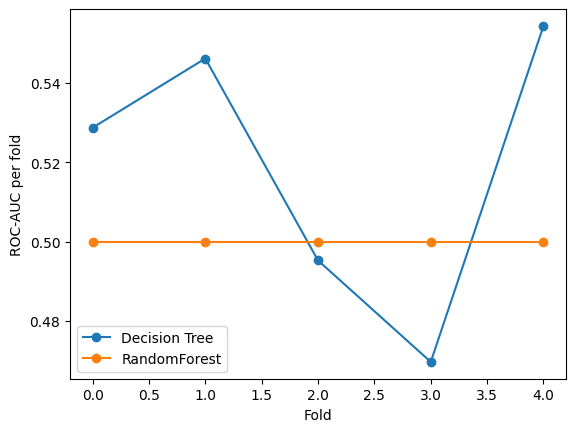

In [84]:
plt.plot(roc_auc_dt, 'o-', label='Decision Tree')
plt.plot(roc_auc_rf, 'o-', label='RandomForest')
plt.ylabel("ROC-AUC per fold")
plt.xlabel("Fold")
plt.legend()
plt.show()

The roc_auc score is Visualised for each classifier.